# Decomposing gate-based circuits: qiskit and myQLM

In this notebook, we show how circuits from Qiskit and myQLM can be converted into Perceval circuits. To do so, we take the example of a simple gate-based circuit producing GHZ states. We then show the translation to a linear optical circuit. We also show the equivalence between the two circuits (gate-based and perceval).

As usual, we start by importing the needed libraries. Note that this notebook requires the installation of Qiskit and MyQLM (which can be easily done with `pip install qiskit` and `pip install myqlm`).

In [191]:
import perceval as pcvl
from perceval.components import catalog
from perceval.converters import QiskitConverter, MyQLMConverter
from perceval.algorithm import Analyzer, Sampler

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

import qat.lang.AQASM as qataqasm

## Conversion from Qiskit Circuit

## GHZ State generation in Qiskit

We first define the circuit generating GHZ states of 3 qubits with Qiskit. To do so, we first act with a Hadamard gate on qubit 0 to put in superposition of state $|0\rangle$ and $|1\rangle$. Then we perform two CNOT gates using qubit 0 as control and qubits 1 and 2 as targets.

In [192]:
# Create a Quantum Circuit acting on the q register
qiskit_circuit = QuantumCircuit(3)

# Add a H gate on qubit 0
qiskit_circuit.h(0)

# Add CX (CNOT) gates on control qubit 0 and target qubits 1 and 2
qiskit_circuit.cx(0, 1)
qiskit_circuit.cx(0, 2)

# Draw the circuit
qiskit_circuit.draw()

┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

We display the final state when starting from the input state $|000\rangle$.

In [193]:
# Set the initial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**3)

# Evolve the state by the quantum circuit
state = state.evolve(qiskit_circuit)

#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

## Conversion of Qiskit circuit to Perceval

With the use of `QiskitConverter`, we can transform the Qiskit circuit into a Perceval circuit. It uses 2 modes per qubit and additional modes for ancillary photons to perform deterministically two-qubit gates. Below the first six modes correspond to the three logical qubits (see the 'Spatial Modes encoding' paragraph in the 'Basics' section of the documentation) of the gate-based circuit above.

The other modes are used to successfully implement two-qubit gates via heralding or post-selection. Heralding employs [4 ancillary modes](https://doi.org/10.1073/pnas.1018839108) while post-selection employs [2 ancillary modes](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.65.062324). With the option `use_postselection=True` in the method `.convert` on a `QiskitConverter` object, every CNOT but the last is implemented with a heralding scheme. Here it means that it would add $4+2$ ancillary modes. The option `use_postselection=False` only implements heralded CNOTs. Here it would mean $4+4$ ancillary modes. Note: the `use_postselection` option is `True` by default.

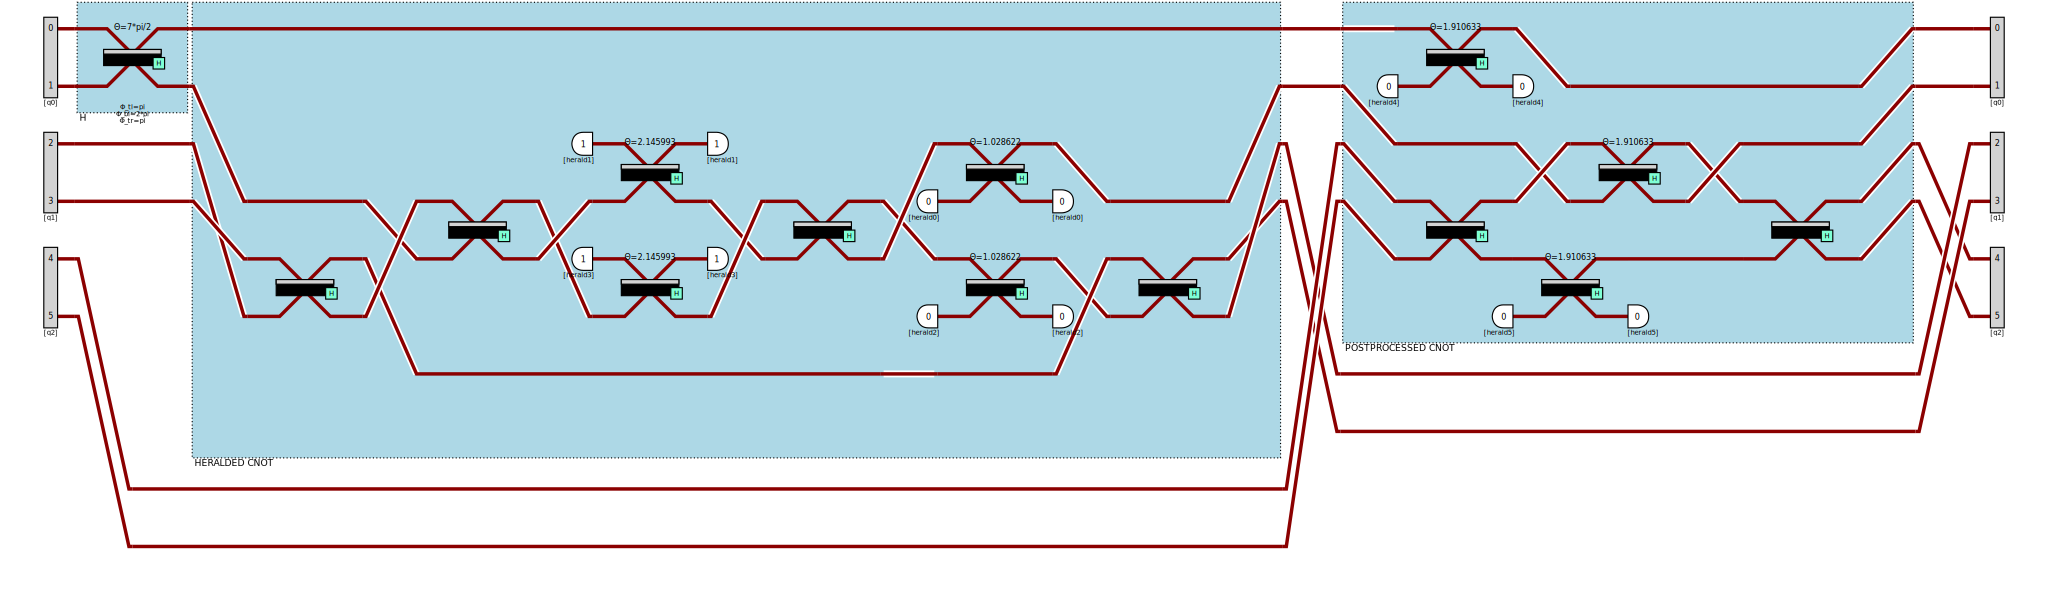

In [194]:
qiskit_converter = QiskitConverter(catalog, backend_name="Naive")
quantum_processor = qiskit_converter.convert(qiskit_circuit, use_postselection=True)
pcvl.pdisplay(quantum_processor, recursive=True)

With this converted circuit, we can now check that the resulting state is the same as before the conversion. By default, the input is the logical state $|000\rangle_L$. Note that where Qiskit displays state in the order $|q_2q_1q_0\rangle_L$, Perceval uses the reverse order $|q_0q_1q_2\rangle_L$, but still shown as Fock states. Here, it doesn't change anything since we end with only $|000\rangle_L$ and $|111\rangle_L$ states.

In [195]:
# Not necessary here
quantum_processor.with_input(pcvl.LogicalState([0,0,0]))

sampler = Sampler(quantum_processor)

output_distribution = sampler.probs()["results"]
pcvl.pdisplay(output_distribution, precision=1e-2, max_v = 4)

state,probability
"|1,0,1,0,1,0>",1/2
"|0,1,0,1,0,1>",1/2
"|1,0,0,1,1,0>",0
"|0,1,1,0,0,1>",0


This circuit can now be converted using a general interferometer decomposition so it can be implemented on a generic photonic chip.

In [196]:
# use either quantum_processor (after Qiskit above) or converted_processor (after myqlm above)
u = quantum_processor.linear_circuit().compute_unitary(use_symbolic=False)

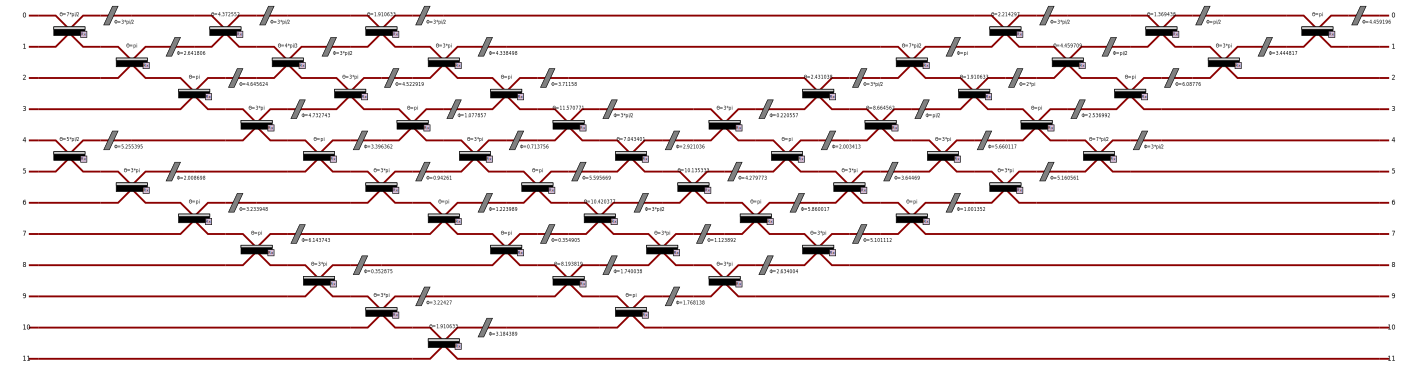

In [197]:
ub = (pcvl.Circuit(2)
      // pcvl.BS(theta=pcvl.Parameter("theta"))
      // (0, pcvl.PS(phi=pcvl.Parameter("φ_a"))))

pc_norm = pcvl.Circuit.decomposition(u, ub, shape="triangle")
pcvl.pdisplay(pc_norm, compact=True, render_size=0.5)

## A cnot based on CZ

Another interesting example we can explore is how to build a cnot from a CZ gate using qiskit or directly the CZ gate of myqlm then convert it to Perceval. We will apply the following equivalence:

![equivalence between cnot and H-CZ-H](../_static/img/cz-cnot-equivalence.png)


The code in Qiskit:

In [198]:
qiskit_circuit = QuantumCircuit(2)

# Add (CNOT) built using equivalence with H-CZ-H
qiskit_circuit.h(1)
qiskit_circuit.cz(0, 1)
qiskit_circuit.h(1)
# Draw the circuit
qiskit_circuit.draw()

q_0: ──────■──────
     ┌───┐ │ ┌───┐
q_1: ┤ H ├─■─┤ H ├
     └───┘   └───┘

Then we call the converter like the previous example

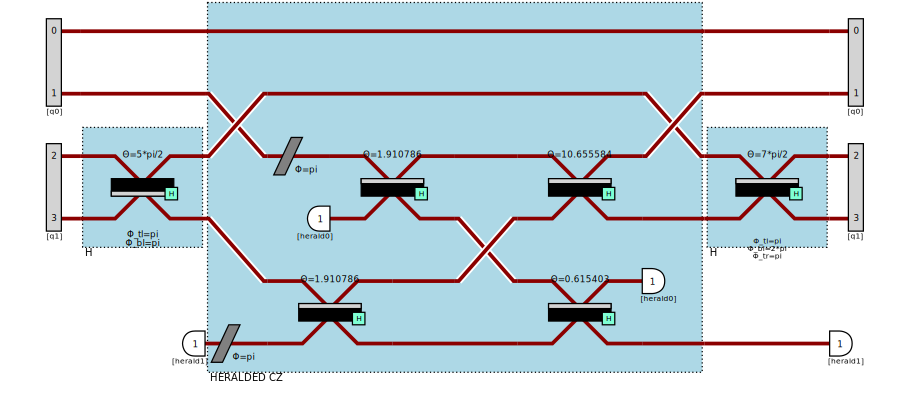

In [199]:
state = Statevector.from_int(0, 2**3)
state = state.evolve(qiskit_circuit)

qiskit_converter = QiskitConverter(catalog, backend_name="SLOS")
quantum_processor = qiskit_converter.convert(qiskit_circuit)

pcvl.pdisplay(quantum_processor, recursive=True) # the perceval processor can be displayed at this point if needed


In [200]:
input_states = [pcvl.BasicState([1, 0, 1, 0]), pcvl.BasicState([1, 0, 0, 1]), pcvl.BasicState([0, 1, 1, 0]), pcvl.BasicState([0, 1, 0, 1])]
analyzer = Analyzer(quantum_processor, input_states)
pcvl.pdisplay(analyzer)

,"|1,0,1,0>","|1,0,0,1>","|0,1,1,0>","|0,1,0,1>"
"|1,0,1,0>",1,0,0,0
"|1,0,0,1>",0,1,0,0
"|0,1,1,0>",0,0,0,1
"|0,1,0,1>",0,0,1,0


This is the truth table of a CNOT gate

## Conversion from MyQLM Circuit

Analogous to `QiskitConverter`, employ a `MyQLMConverter` object to convert a MyQLM circuit to a Perceval processor with each qubit of the circuit represented by 2 modes and additional modes for ancillary photons to perform deterministically two-qubit gates. (Read above in section for qiskit converter for a discussion on how ancillary modes are set).

## Circuit to generate GHZ State in MyQLM

In [201]:
# Create a myqlm program
qprog = qataqasm.Program()

# Allocate qbits to the Program
qbits = qprog.qalloc(3)

# Add gates
qprog.apply(qataqasm.H, qbits[0])
qprog.apply(qataqasm.CNOT, qbits[0], qbits[1])
qprog.apply(qataqasm.CNOT, qbits[0], qbits[2])

# Convert program to myqlm circuit
myqlm_circuit = qprog.to_circ()

myqlm_circuit.display()

## Conversion of Myqlm circuit to Perceval

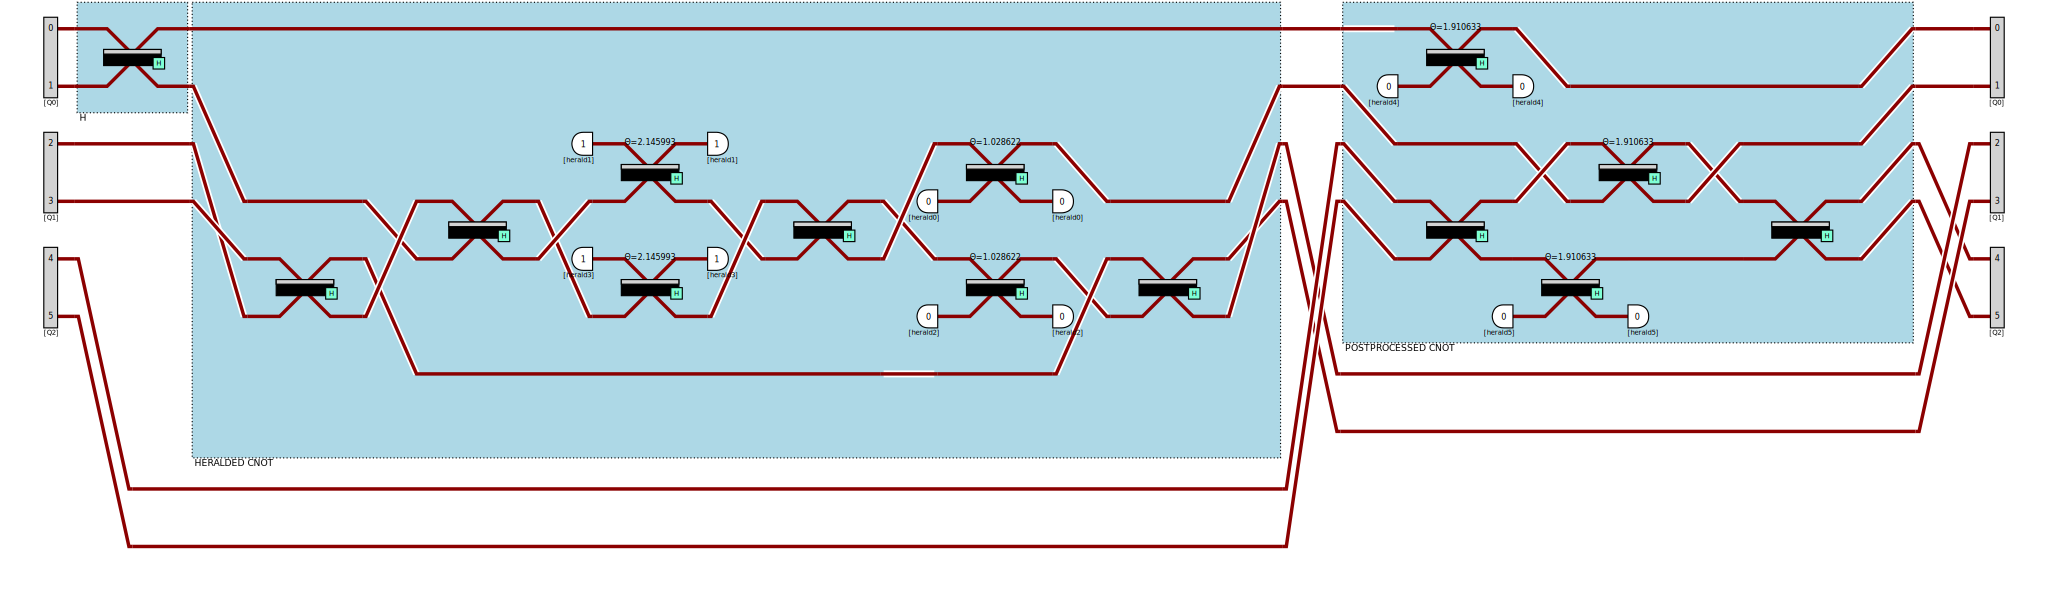

In [202]:
myqlm_converter = MyQLMConverter(catalog, backend_name="Naive")
converted_processor = myqlm_converter.convert(myqlm_circuit, use_postselection=True)
pcvl.pdisplay(converted_processor, recursive=True)

In [205]:
# computing results with converted processor from myqlm
converted_processor.with_input(pcvl.LogicalState([0,0,0]))

sampler = Sampler(converted_processor)

output_distribution_myqlm_pcvl = sampler.probs()["results"]
pcvl.pdisplay(output_distribution_myqlm_pcvl, precision=1e-2, max_v = 4)

state,probability
"|1,0,1,0,1,0>",1/2
"|0,1,0,1,0,1>",1/2
"|1,0,0,1,1,0>",0
"|0,1,1,0,0,1>",0


Note : The result is exactly the same as previously obtained from converter from Qiskit and is also the expected result.

## Few remarks
- Controlflow operations such as measurement operator in the qiskit ciruit or `qiskit.circuit.QuantumCircuit.if_test` are not supported.
- Custom gates from Qiskit are also not supported at the moment (see [Issue#201](https://github.com/Quandela/Perceval/issues/201)).
- Only 1-Qubit gates and the following 2-Qubits gates - CNOT, CSIGN(/CZ), and, SWAP from MyQLM are supported.